# Import Required Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
import scipy
import librosa

from scipy.io import wavfile

# Load Data

In [3]:
root_dir = '/mnt/d/Datasets/audio_cats_dogs/cats_dogs/'

In [4]:
files_temp = os.listdir(root_dir)
files_temp[:5]

['cat_1.wav', 'cat_10.wav', 'cat_100.wav', 'cat_101.wav', 'cat_102.wav']

In [5]:
files = []
for file in files_temp:
    if file.endswith('.wav'):
        files.append(root_dir + file)

In [6]:
df = pd.DataFrame({'File Path': files})
df.head()

,File Path
0,/mnt/d/Datasets/audio_cats_dogs/cats_dogs/cat_...
1,/mnt/d/Datasets/audio_cats_dogs/cats_dogs/cat_...
2,/mnt/d/Datasets/audio_cats_dogs/cats_dogs/cat_...
3,/mnt/d/Datasets/audio_cats_dogs/cats_dogs/cat_...
4,/mnt/d/Datasets/audio_cats_dogs/cats_dogs/cat_...


In [7]:
df['Label'] = df['File Path'].apply(lambda x: 1 if 'cat' in x.split('/')[-1] else 0)

In [8]:
df.head()

,File Path,Label
0,/mnt/d/Datasets/audio_cats_dogs/cats_dogs/cat_...,1
1,/mnt/d/Datasets/audio_cats_dogs/cats_dogs/cat_...,1
2,/mnt/d/Datasets/audio_cats_dogs/cats_dogs/cat_...,1
3,/mnt/d/Datasets/audio_cats_dogs/cats_dogs/cat_...,1
4,/mnt/d/Datasets/audio_cats_dogs/cats_dogs/cat_...,1


In [9]:
df['Label'].value_counts()

Label
1    164
0    113
Name: count, dtype: int64

In [10]:
df.shape

(277, 2)

<Axes: ylabel='count'>

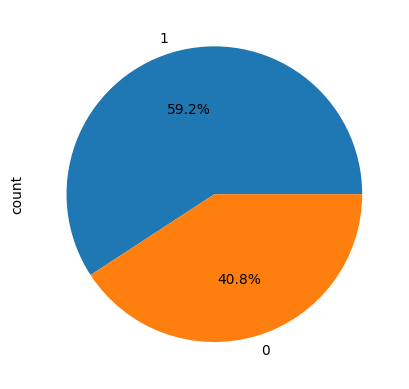

In [11]:
df['Label'].value_counts().plot(kind='pie', autopct='%.1f%%')

# Load Model

In [12]:
yamnet_url = "https://tfhub.dev/google/yamnet/1"
yamnet = hub.load(yamnet_url)

# Preprocess

In [28]:
X = df['File Path']
y = df['Label']

In [29]:
def train_validate_test_split(df):
    df = df.sample(frac=1)
    train_end = int(.9 * len(df.index))
    validate_end = int(.05 * len(df.index)) + train_end
    train = df.iloc[:train_end]
    validate = df.iloc[train_end:validate_end]
    test = df.iloc[validate_end:]
    return train, validate, test

df_train, df_validation, df_test = train_validate_test_split(df)
print(len(df_train), len(df_validation), len(df_test))

249 13 15


In [61]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train['File Path'], df_train['Label']))
valid_ds = tf.data.Dataset.from_tensor_slices((df_validation['File Path'], df_validation['Label']))
test_ds = tf.data.Dataset.from_tensor_slices((df_test['File Path'], df_test['Label']))

In [1]:
# https://www.tensorflow.org/tutorials/audio/transfer_learning_audio?hl=en
# def load_wav_16k_mono

In [63]:
def wav_map(file_path, label):
    return load_wav_16k_mono(file_path), label

In [64]:
def extract_yamnet_embeddings(wav_data, targets):
    scores, embeddings, spectrogram = yamnet(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings, tf.repeat(targets, num_embeddings))

In [65]:
def process_dataset(dataset):
    return (
        dataset
        .map(wav_map)
        .map(extract_yamnet_embeddings)
        .unbatch()
        .cache()
        .shuffle(1000)
        .batch(32)
        .prefetch(tf.data.AUTOTUNE)
    )

train_ds = process_dataset(train_ds)
valid_ds = process_dataset(valid_ds)
test_ds = process_dataset(test_ds)

2024-01-06 00:41:56.064824: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
2024-01-06 00:41:56.092389: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available


# Model

In [57]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [60]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [61]:
history = model.fit(train_ds, epochs=50, validation_data=valid_ds, callbacks=[early_stopping])

Epoch 1/50
107/107 [==============================] - 1s 7ms/step - loss: 0.0059 - accuracy: 0.9979 - val_loss: 0.5736 - val_accuracy: 0.9193
Epoch 2/50
107/107 [==============================] - 1s 6ms/step - loss: 0.0151 - accuracy: 0.9974 - val_loss: 0.6004 - val_accuracy: 0.9283
Epoch 3/50
107/107 [==============================] - 1s 6ms/step - loss: 0.0114 - accuracy: 0.9977 - val_loss: 0.5060 - val_accuracy: 0.9327
Epoch 4/50
107/107 [==============================] - 1s 6ms/step - loss: 0.0051 - accuracy: 0.9991 - val_loss: 0.4023 - val_accuracy: 0.9417
Epoch 5/50
107/107 [==============================] - 1s 6ms/step - loss: 0.0379 - accuracy: 0.9988 - val_loss: 0.3713 - val_accuracy: 0.9507
Epoch 6/50
107/107 [==============================] - 1s 7ms/step - loss: 0.0302 - accuracy: 0.9982 - val_loss: 0.3829 - val_accuracy: 0.9507
Epoch 7/50
107/107 [==============================] - 1s 6ms/step - loss: 0.0064 - accuracy: 0.9982 - val_loss: 0.3930 - val_accuracy: 0.9507
Epoch 

In [64]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.005874,0.997945,0.573623,0.919282
1,0.015145,0.997358,0.600354,0.928251
2,0.011366,0.997652,0.506030,0.932735
3,0.005148,0.999119,0.402273,0.941704
4,0.037946,0.998826,0.371312,0.950673


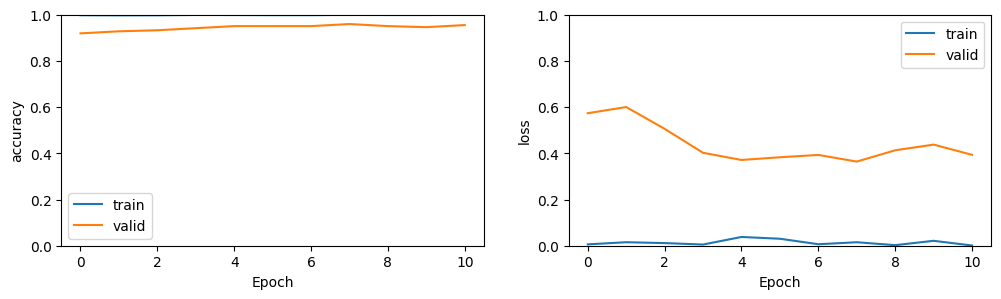

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
ax = axes.ravel()

for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history['val_' + metric])
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel(metric)
    ax[i].set_ylim([0, 1])
    ax[i].legend(['train', 'valid'])

plt.show()

In [68]:
results = model.evaluate(test_ds, verbose=0)
print(f'Test Loss: {results[0]}')
print(f'Test Accuracy: {results[1]}')

Test Loss: 0.16961297392845154
Test Accuracy: 0.9669811129570007
